# Measure Disease associations Gene Edge Recall

This notebook is designed to estimate how many hetionet edges can be recalled from this weakly supervised approach.
After the discriminator model has been trained, the last step is to predict whether every candidate sentence mentions a disease associates gene relationship.
Following the predictions, the next step is to group each candidate sentence based on each candidate pair and take the max value of each group.
This max value represents the probability that an edge should or does exist.
Lastly, once each candidate has been scored I use the precision recall curve to estimate how many edges can be recovered from this method.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import math
from pathlib import Path

import numpy as np
import pandas as pd
import plotnine as p9
import plydata as ply
import plydata.tidy as ply_tdy
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sqlalchemy import create_engine

In [2]:
# Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmed_central_db"

# Path subject to change for different os
database_str = (
    f"postgresql+psycopg2://{username}:{password}@/{dbname}?host=/var/run/postgresql"
)
conn = create_engine(database_str)

In [3]:
hetionet_dag_map_df = pd.read_csv(
    Path("../snorkeling_helper/label_functions/knowledge_bases")
    / "disease_associates_gene.tsv.xz",
    sep="\t",
)
hetionet_dag_map_df >> ply.slice_rows(5)

/home/danich1/anaconda3/envs/snorkeling_full_text/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.85860,1
1,1,A1BG,DOID:1319,brain cancer,NaN,0,0,0,0.36785,0
2,1,A1BG,DOID:1324,lung cancer,NaN,0,2,1,0.15465,0
3,1,A1BG,DOID:263,kidney cancer,NaN,0,0,0,0.87328,1
4,1,A1BG,DOID:1793,pancreatic cancer,NaN,0,10,1,0.17837,0


In [4]:
sentence_prediction_df = pd.read_csv(
    "output/all_predicted_dag_sentences.tsv", sep="\t"
) >> ply.arrange("candidate_id")
sentence_prediction_df >> ply.slice_rows(5)

,pred,candidate_id
0,0.706093,121
1,0.707084,122
2,0.658592,124
3,0.798254,148
4,0.645717,190


In [5]:
sql = """
select candidate_id, disease_cid as doid_id, gene_cid as entrez_gene_id
from disease_gene inner join (
    select sentence_id, document_id
    from sentence
) as sentence_map
on disease_gene.sentence_id = sentence_map.sentence_id
where section = 'title' or section ='abstract'
"""
candidate_to_sentence_map_df = (
    pd.read_sql(sql, conn)
    >> ply_tdy.separate_rows("entrez_gene_id", sep=";")
    >> ply.call(".astype", {"entrez_gene_id": int})
)
candidate_to_sentence_map_df >> ply.slice_rows(5)

,candidate_id,doid_id,entrez_gene_id
0,121,DOID:3070,1434
1,122,DOID:3070,1434
2,124,DOID:3070,1434
3,148,DOID:2355,4524
4,190,DOID:10763,173


# Merge Predictions with Candidates and Hetionet Map

In [6]:
all_dag_predictions_df = (
    sentence_prediction_df
    >> ply.inner_join(candidate_to_sentence_map_df, on="candidate_id")
    >> ply.inner_join(
        hetionet_dag_map_df >> ply.select("-sources", "-n_sentences"),
        on=["doid_id", "entrez_gene_id"],
    )
)
all_dag_predictions_df >> ply.slice_rows(5)

,pred,candidate_id,doid_id,entrez_gene_id,gene_symbol,doid_name,hetionet,has_sentence,partition_rank,split
0,0.706093,121,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.73874,1
1,0.707084,122,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.73874,1
2,0.658592,124,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.73874,1
3,0.726981,248507,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.73874,1
4,0.749319,511705,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.73874,1


In [7]:
all_dag_df = (
    all_dag_predictions_df
    >> ply.group_by("doid_id", "entrez_gene_id")
    >> ply.define(
        pred_max="max(pred)", pred_mean="mean(pred)", pred_median="median(pred)"
    )
    >> ply.select("-pred", "-candidate_id")
    >> ply.distinct()
    >> ply.ungroup()
    >> ply_tdy.gather("metric", "score", ["pred_max", "pred_mean", "pred_median"])
)
all_dag_df >> ply.slice_rows(10)

,doid_id,entrez_gene_id,gene_symbol,doid_name,hetionet,has_sentence,partition_rank,split,metric,score
0,DOID:3070,1434,CSE1L,malignant glioma,0,1,0.738740,1,pred_max,0.954886
1,DOID:2355,4524,MTHFR,anemia,1,1,0.398270,0,pred_max,0.878160
2,DOID:10763,173,AFM,hypertension,0,1,0.759880,1,pred_max,0.926797
3,DOID:8893,3605,IL17A,psoriasis,1,1,0.104070,0,pred_max,0.916013
4,DOID:2377,55768,NGLY1,multiple sclerosis,0,1,0.723770,1,pred_max,0.544663
5,DOID:1612,1956,EGFR,breast cancer,1,1,0.062298,0,pred_max,0.967520
6,DOID:1612,5728,PTEN,breast cancer,1,1,0.793100,1,pred_max,0.957922
7,DOID:1612,5293,PIK3CD,breast cancer,1,1,0.538700,0,pred_max,0.864579
8,DOID:11054,2261,FGFR3,urinary bladder cancer,1,1,0.095635,0,pred_max,0.928092
9,DOID:7148,3569,IL6,rheumatoid arthritis,1,1,0.424320,0,pred_max,0.934345


In [8]:
test_entity_df = all_dag_df >> ply.query("split == 2")
test_entity_df >> ply.slice_rows(5)

,doid_id,entrez_gene_id,gene_symbol,doid_name,hetionet,has_sentence,partition_rank,split,metric,score
10,DOID:9206,100508689,LOC100508689,Barrett's esophagus,0,1,0.91940,2,pred_max,0.906463
12,DOID:9352,173,AFM,type 2 diabetes mellitus,0,0,0.94394,2,pred_max,0.944439
20,DOID:2531,207,AKT1,hematologic cancer,1,1,0.93864,2,pred_max,0.950269
27,DOID:2531,954,ENTPD2,hematologic cancer,0,0,0.92122,2,pred_max,0.884520
34,DOID:2355,7018,TF,anemia,1,1,0.99302,2,pred_max,0.921203


# Determine Precision and Recall

In [9]:
performance_map = dict()

In [10]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_max'") >> ply.pull("score"),
)

performance_map["PR"] = (
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_max/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = pd.DataFrame(
    {"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold}
) >> ply.define(model=f'"pred_max/AUC={auc(fpr, tpr):.2f}"')

In [11]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_mean'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_mean/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_mean/AUC={auc(fpr, tpr):.2f}"')
)

In [12]:
precision, recall, pr_threshold = precision_recall_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

fpr, tpr, roc_threshold = roc_curve(
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet"),
    test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("score"),
)

performance_map["PR"] = performance_map["PR"].append(
    pd.DataFrame(
        {
            "precision": precision,
            "recall": recall,
            "pr_threshold": np.append(pr_threshold, 1),
        }
    )
    >> ply.define(model=f'"pred_median/AUC={auc(recall, precision):.2f}"')
)

performance_map["AUROC"] = performance_map["AUROC"].append(
    pd.DataFrame({"fpr": fpr, "tpr": tpr, "roc_threshold": roc_threshold})
    >> ply.define(model=f'"pred_median/AUC={auc(fpr, tpr):.2f}"')
)

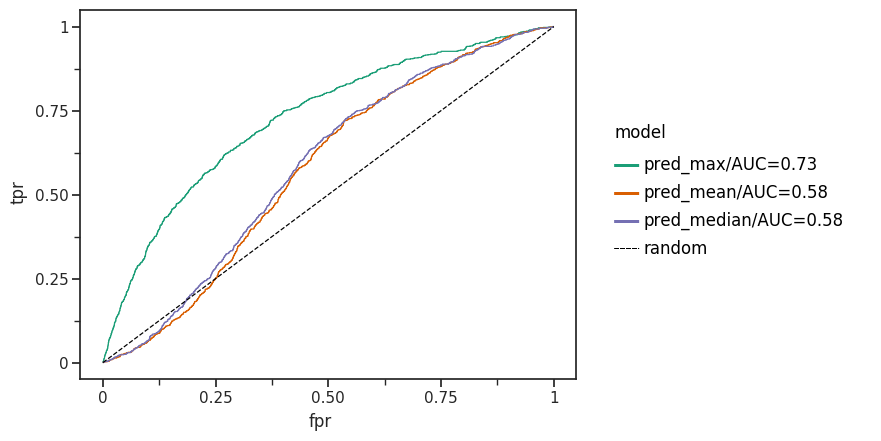

<ggplot: (-9223363259432165155)>


In [13]:
g = (
    p9.ggplot(
        performance_map["AUROC"]
        >> ply.call(
            ".append",
            pd.DataFrame(
                {
                    "fpr": [0, 0.25, 0.5, 0.75, 1],
                    "tpr": [0, 0.25, 0.5, 0.75, 1],
                    "model": "random",
                }
            ),
        )
    )
    + p9.aes(x="fpr", y="tpr", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
)
print(g)

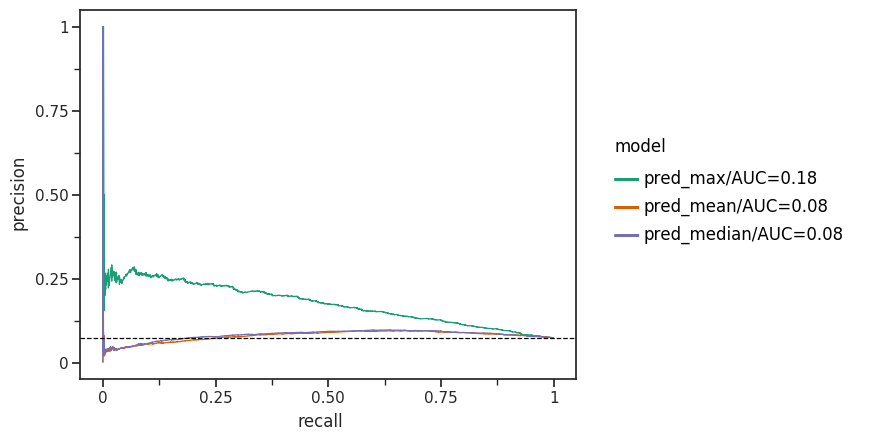

<ggplot: (-9223363259425797716)>


In [14]:
g = (
    p9.ggplot(performance_map["PR"])
    + p9.aes(x="recall", y="precision", group="model", color="model", linetype="model")
    + p9.geom_line()
    + p9.theme_seaborn("white")
    + p9.scale_color_manual(["#1b9e77", "#d95f02", "#7570b3", "#000000"])
    + p9.scale_linetype_manual(["solid", "solid", "solid", "dashed"])
    + p9.geom_hline(
        yintercept=(
            test_entity_df >> ply.query("metric=='pred_median'") >> ply.pull("hetionet")
        ).mean(),
        linetype="dashed",
    )
)
print(g)

## Estimate number of new Edges Added

In [15]:
df_iterator = (
    performance_map["PR"]
    >> ply.query("model.str.contains('max')& pr_threshold < 1")
    >> ply.call(".round", {"pr_threshold": 2})
    >> ply.distinct("pr_threshold", "last")
)

edges_added_records = []
for idx, row in df_iterator.iterrows():
    cutoff = row["pr_threshold"]

    values_added = (
        all_dag_df
        >> ply.query("metric.str.contains('max')")
        >> ply.query("score >= @cutoff")
        >> ply.pull("hetionet")
    )

    edges_added_records.append(
        {
            "edges": values_added.sum(),
            "in_hetionet": "Existing",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )

    edges_added_records.append(
        {
            "edges": values_added.shape[0] - values_added.sum(),
            "in_hetionet": "Novel",
            "precision": row["precision"],
            "sen_cutoff": cutoff,
        }
    )


edges_added_df = pd.DataFrame.from_records(edges_added_records)
edges_added_df >> ply.slice_rows(10)

,edges,in_hetionet,precision,sen_cutoff
0,8207,Existing,0.072548,0.38
1,103663,Novel,0.072548,0.38
2,8206,Existing,0.072504,0.39
3,103602,Novel,0.072504,0.39
4,8206,Existing,0.072568,0.40
5,103534,Novel,0.072568,0.40
6,8203,Existing,0.072620,0.41
7,103451,Novel,0.072620,0.41
8,8199,Existing,0.072718,0.42
9,103338,Novel,0.072718,0.42


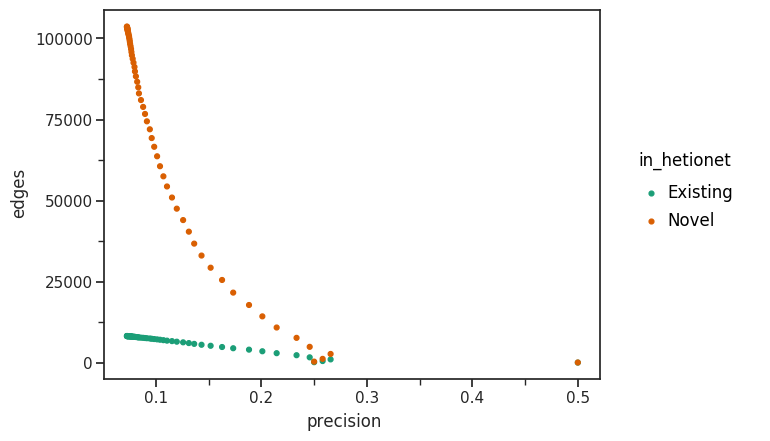

<ggplot: (8739553177180)>


In [16]:
g = (
    p9.ggplot(edges_added_df >> ply.query("edges > 0 & precision > 0"))
    + p9.aes(x="precision", y="edges", color="in_hetionet")
    + p9.geom_point()
    + p9.theme_seaborn("white")
    + p9.scale_color_brewer(type="qual", palette=2)
)
print(g)

In [17]:
edges_df = pd.DataFrame.from_records(
    [
        {
            "recall": (
                all_dag_df
                >> ply.query("metric=='pred_max' & score > 0.5")  # precision 0.073798
                >> ply.pull("hetionet")
            ).sum()
            / all_dag_df.query("hetionet == 1").shape[0],
            "edges": (
                all_dag_df
                >> ply.query("metric=='pred_max' & score > 0.5")
                >> ply.pull("hetionet")
            ).sum(),
            "in_hetionet": "Existing",
            "relation": "DaG",
        },
        {
            "edges": (
                all_dag_df
                >> ply.query("metric=='pred_max' & score > 0.5")
                >> ply.query("hetionet==0")
            ).shape[0],
            "in_hetionet": "Novel",
            "relation": "DaG",
        },
    ]
)

edges_df

,recall,edges,in_hetionet,relation
0,0.331669,8172,Existing,DaG
1,NaN,101518,Novel,DaG


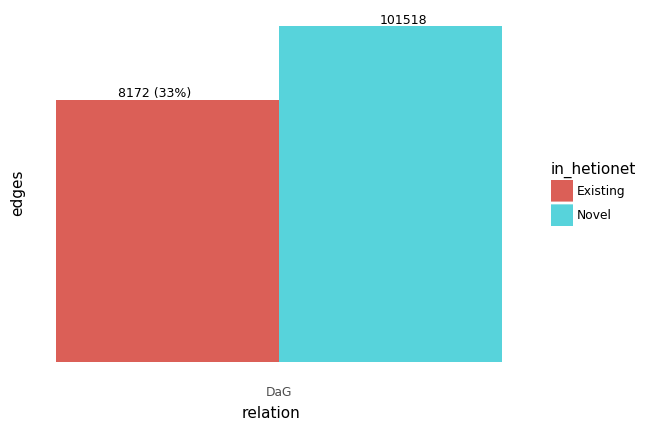

<ggplot: (8739579381382)>


In [18]:
g = (
    p9.ggplot(edges_df, p9.aes(x="relation", y="edges", fill="in_hetionet"))
    + p9.geom_col(position="dodge")
    + p9.geom_text(
        p9.aes(
            label=(
                edges_df.apply(
                    lambda x: f"{x['edges']} ({x['recall']*100:.0f}%)"
                    if not math.isnan(x["recall"])
                    else f"{x['edges']}",
                    axis=1,
                )
            )
        ),
        position=p9.position_dodge(width=1),
        size=9,
        va="bottom",
    )
    + p9.scale_y_log10()
    + p9.theme(
        axis_text_y=p9.element_blank(),
        axis_ticks_major=p9.element_blank(),
        rect=p9.element_blank(),
    )
)
print(g)

# Take home messages

1. Recall is okay. Achieves 33% which is better than originally thought.
2. If the discriminator model trained correctly I hypothesize that the recall would be a lot more higher.